## Lab 6 Part II: Plotting Color-Filled Upper-Air Wind Plots and Ageostrophic Wind Plots
<br /><br />

In this tutorial, we are going to create plots for the full horizontal wind and for the ageostrophic wind at 300 hPa and 500 hPa, as derived from from GFS analysis data.
<br />
### Module Documentation

1. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
2. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
3. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
4. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
5. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
6. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
7. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
8. Matplotlib Color Maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
9. Matplotlib Contourf: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html
10. Matplotlib Vectors: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html
11. MetPy Calculations: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html
12. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [14]:
#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the metpy submodule units import the units function
from metpy.units import units

#import the calculation submodule form the metpy module and save it to the variable calc
import metpy.calc as calc

<br /><br />
2. For this part of the lab, we will consider two different dates, using 300-hPa data for one date and 500-hPa data for the other.  Let's start with 1200 UTC October 28, 2021 at 500 hPa.  Create variables for this time and for the level (in hPa) of interest.

In [15]:
map_time=datetime(2021,10,28,12)
level=500

<br /><br />
3.  We are ready to open and process our data.  As in previous labs, we put the data processing in a function since we are going to use it multiple times.

In [16]:
"""
Below, I define a function to retrieve and process GFS analysis upper-air data.  This function opens the GFS analysis data, retains only the desired pressure level, 
converts the wind units, calculates the ageostrophic wind, and adds the wind magnitude to the dataset.

INPUT:
    level : INTEGER
        The level in hPa at which you want upper-air data.
    time : DATETIME
        The time at which you would like upper-air data.
    
OUTPUT:
    leveled_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data

"""

def process_upper_air_data(level, time):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_6/"
    
    """
    Open the GFS data using xarray.  Since the data are once again GRIB-formatted data, we can use xarray the same way we did in Lab 4.  Be sure to add filter_by_keys={'typeOfLevel': 'isobaricInhPa'}.
    """
    model_data =xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    
    """
    We only want data at a single isobaric level.  Limit the data in the xarray to only this specified level.
    """
    leveled_data =model_data.sel(isobaricInhPa =level)
        
    """
    Here I start to calculate the ageostrophic wind.  The first step is to find the distance between each cell from it's neighbor.  Below I use the 
    metpy calculation function lat_lon_grid_deltas to find the x distance and the y distance of each cell to it's neighbors.  This function only 
    requires the latitude and longitude data from the model.
    """
    dx, dy = calc.lat_lon_grid_deltas(leveled_data["longitude"], leveled_data["latitude"])
    
    """
    In the lines below, I convert our u and v wind components to kt, saving them back to our dataset and thus
    overwriting the u and v wind components contained in the dataset.
    """
    leveled_data['u'] = leveled_data["u"].metpy.convert_units('kt')
    leveled_data['v'] = leveled_data["v"].metpy.convert_units('kt')
    
    """
    Here I use MetPy's ageostropic_wind calculation function to calculate the ageostrophic wind.  
    This function outputs the u and v components of the ageostrophic wind.
    The first argument is the geopotential height.
    The second argument is the u wind component.
    The third argument is the v wind component.
    Dx is the x distance between grid cells in the x direction.
    Dy is the x distance between grid cells in the y direction.
    latitude is the latitude of each cell so the function can properly calculate the Coriolis parameter.
    """
    u_ageo, v_ageo = calc.ageostrophic_wind(leveled_data["gh"], leveled_data["u"], leveled_data["v"], dx=dx, dy=dy, latitude=leveled_data["latitude"])
    
    """
    Assign the ageostrophic components to the xarray dataset.  This keeps everything in one place and your code stays clean.
    assign(variable_name=variable_data)    
    """
    leveled_data = leveled_data.assign(u_ageostrophic=u_ageo)
    leveled_data = leveled_data.assign(v_ageostrophic=v_ageo)
    
    """
    It will be useful to have the ageostrophic wind magnitude later.  In the lines below, I calculate the ageostrophic wind
    magnitude and assign it back to the xarray dataset.
    """
    ageo_mag = ((u_ageo ** 2)+(v_ageo**2)) ** 0.5
    leveled_data = leveled_data.assign(ageostrophic_mag=ageo_mag)
    
    """
    We will also need the full wind magnitude.  In the lines below, I calculate the wind magnitude and assign it back
    to the xarray dataset.
    """
    mag = ((leveled_data['u']**2) + (leveled_data['v']**2)) ** 0.5
    leveled_data = leveled_data.assign(wind_mag=mag)
    
    """
    Finally, our data processing is complete and so we need to return the processed data.
    """
    return leveled_data

<br /><br />
4. Call the data processing script you just created for the time and level we specified earlier. Save the output from this function to an appropriately named variable.

In [17]:
leveled_data=process_upper_air_data(level,map_time)


Ignoring index file '/data/AtmSci360/Lab_6/102821_12_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

<br /><br />
5. To save some repeated code since we need to make two different plots, let's place the initial plotting information in a seperate function to be called by our plotting functions.  This function establishes the map projection, plot size, and geographic data to include.

In [18]:
"""
Below, I define a function to initialize a plot over the United States.  This function creates the plot, sets up the projection, 
sets the extent, and adds the desired geographic data.

OUTPUT:
    ax : MATPLOTLIB AXES
        The initialized plot
"""

def initialize_plot():
    
    """
    Create a Lambert Conic Conformal Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conic Conformal projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
        
    
    """
    Create a figure with a size of 1150px x 800px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig=plt.figure(figsize=(11.5,8),dpi=300)
    ax = plt.subplot(projection = proj)
        
    """
    Add the appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """

    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    
    """
    Limit the map to between 125°-65°W longitude and 23°-60°N latitude.
    """
    
    ax.set_extent((-125, -65, 23, 60))
    
    return ax

<br /><br />
5.  We are now ready to plot the data.  In the plotting function to be created, we will plot the geopotential heights, wind barbs, and filled contours (for wind speed) for the level we specify.  Watch the comments for areas that you need to fill in.

In [19]:
"""
Below, I define a function to plot upper-air wind data.  This function creates line isopleths for the geopotential height, color fill isopleths
for the wind magnitude, and wind barbs for the wind.

INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data
    level : INTEGER
        The level that the plot is valid for.
    data : DATETIME
        The date and time that the plot is valid for.
"""

def wind_gfs_upper_air_plot(model_data, level, date):
    
    """
    Initialize the plot using the function we created.
    """
    ax = initialize_plot()
    
    """
    As with previous labs, first we want to smooth the geopotential height data to make them easier to analyze.  
    Setup the Gaussian filter for the geopotential heights ('gh'). Choose an appropriate smoothing value for these data.
    """
    smooth_heights =gaussian_filter(model_data["gh"].values,2) 
    
    """
    We can now isopleth the smoothed geopotential height data.  In the line below, add the command to isopleth the smoothed 
    geopotential heights and add styling information to make the contours easier to read.
    """
    cont_p =plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,60),linewidths=0.5, colors="black", transform=crs.PlateCarree()) 
    
    """
    Every contour plot needs labels for each contour, so we add contour labels below.  Add styling information to make the contour labels easier to read.
    """
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'))
              
    """
    Next, we plot color filled contours for wind speed.  As with the geopotential height, we must first smooth the data.
    In the line below setup the gaussian filter for the wind magnitude data (wind_mag).
    """
    smooth_wind =gaussian_filter(model_data["wind_mag"].values,2) 
              
    """
    In the line below I plot the color-filled contours for the wind speed.  The color fill contour command (plt.contourf) works similarly to the contour command (plt.contour).
    The first two arguments are the longitude and latitude data, respectively.
    The third argument is what variable to contour, here being the smoothed wind speed field.
    The fourth argument is the contour interval.  Here I specify 40, 50, 75, 100, 150, 200, and 225 knots.  You can also use the np.arange function to define this (e.g., np.arange(0,230,10)).
    The fifth argument is the color map to use to shade the color-filled contours.  This argument uses the same colormaps we looked at back in Lab 1.
    The sixth argument is our data's coordinate system.
    The seventh argument is the drawing order.  It is useful to plot color-filled contours early, otherwise these contours will plot over other data.
    The last argument is the transparency of the color shading.  It is useful to reduce the transparency in color filled plots to make the plot in general easier to read.
    """
    cont = plt.contourf(model_data["longitude"].values, model_data["latitude"].values,smooth_wind, [40,50,75,100,150,200,225], cmap='twilight', transform=crs.PlateCarree(), zorder=1, alpha=0.6)
    
              
    """
    Next, we need to add a color bar to provide a reference to the shaded colors.  In the line below,
    I tell matplotlib to build a color bar from the color-filled contours we created before (cont).
    """
    cbar = plt.colorbar(cont)
              
    """
    Our color bar needs a label to describe it.
    The first argument is the color bar label's text.
    The second argument is the color bar label's text size.  Larger values increase the text size and smaller values decrease the text size.
    The final argument is the text's weight.  This determines the boldness of the label text.
    """
    cbar.set_label("Wind Speed (kt)", size=12, weight="bold")
    
    
    """
    Now, we begin plotting the wind barbs.  The first part of setting up the wind barbs is determining how to space the data.  There are data points every 0.25° latitude
    and longitude, which is too frequent to be able to draw wind barbs at every location.  Instead, we can space the wind barbs by skipping a specific number of data points.
    In the case below, we retain data only every 7 points (about ~150 km apart).  
    
    In the two lines below, I set a variable for x and y array slices to allow the user to have different values for numbers of points to skip 
    in the x and y direction.  The command I'm using is essentially like what you would use for an array.
    
    array[start:stop:skip] = array[slice(start,stop,skip)]
    
    Using 'None' for the start and stop arguments ensures the filtering applies to the entire dataset.
    """
    wind_slice_x = slice(None, None, 12)
    wind_slice_y = slice(None, None, 12)
    
    """
    Below is the matplotlib command to plot wind barbs.  The first and second arguments are the x (longitude) and y (latitude) values, respectively.  
    Note that latitude and longitude are 1D whereas the wind variables are 2D.  Thus, for position data, we only need to use the wind slice direction that is appropriate.
    The third and fourth arguments are the u- and v-wind components.  We need to use both wind slices since our data is 2D.
    The fifth argument (color='black') determines the wind barb colors.  The matplotlib colors link can once again be used to see what colors you can use to plot the barbs.
    The sixth argument specifies the data's horizonal coordinate system. 
    The seventh argument (linewidth=0.6) determines the barb's width.  Larger values make them thicker and smaller values make them thinner.
    The final argument (length=4) determines the barb's length is.  Larger values make the barbs longer and smaller values make them shorter.
    """
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    """
    Add latitude and longitude gridlines for reference.
    Argument one determines if the labels (e.g. 45°N) appear in the plot.
    Argument two determines if the labels are decimal degrees or degrees minutes seconds.  True is degreees mintues seconds
    and false is decimal degrees.
    Argument three determines if the longitude value labels are plotted on the line inside the plot or outside.  True is
    inside the plot and false is outside the plot.
    Argument four determines if the latitude value labels are plotted on the line inside the plot or outside.  True is
    inside the plot and false is outside the plot.
    The last three arguments are normal matplotlib styling arguments.
    """
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color="k", linestyle="--", alpha=0.5)
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
    plot_title= f"{str(level)} hPa Wind Speed Observations at {map_time:%m/%d/%Y %H%M} UTC"
    plt.title(plot_title, weight="bold")
    plt.show()                 


<br /><br />
6. Call the plotting function you just created for the time and level we specified earlier.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iterati

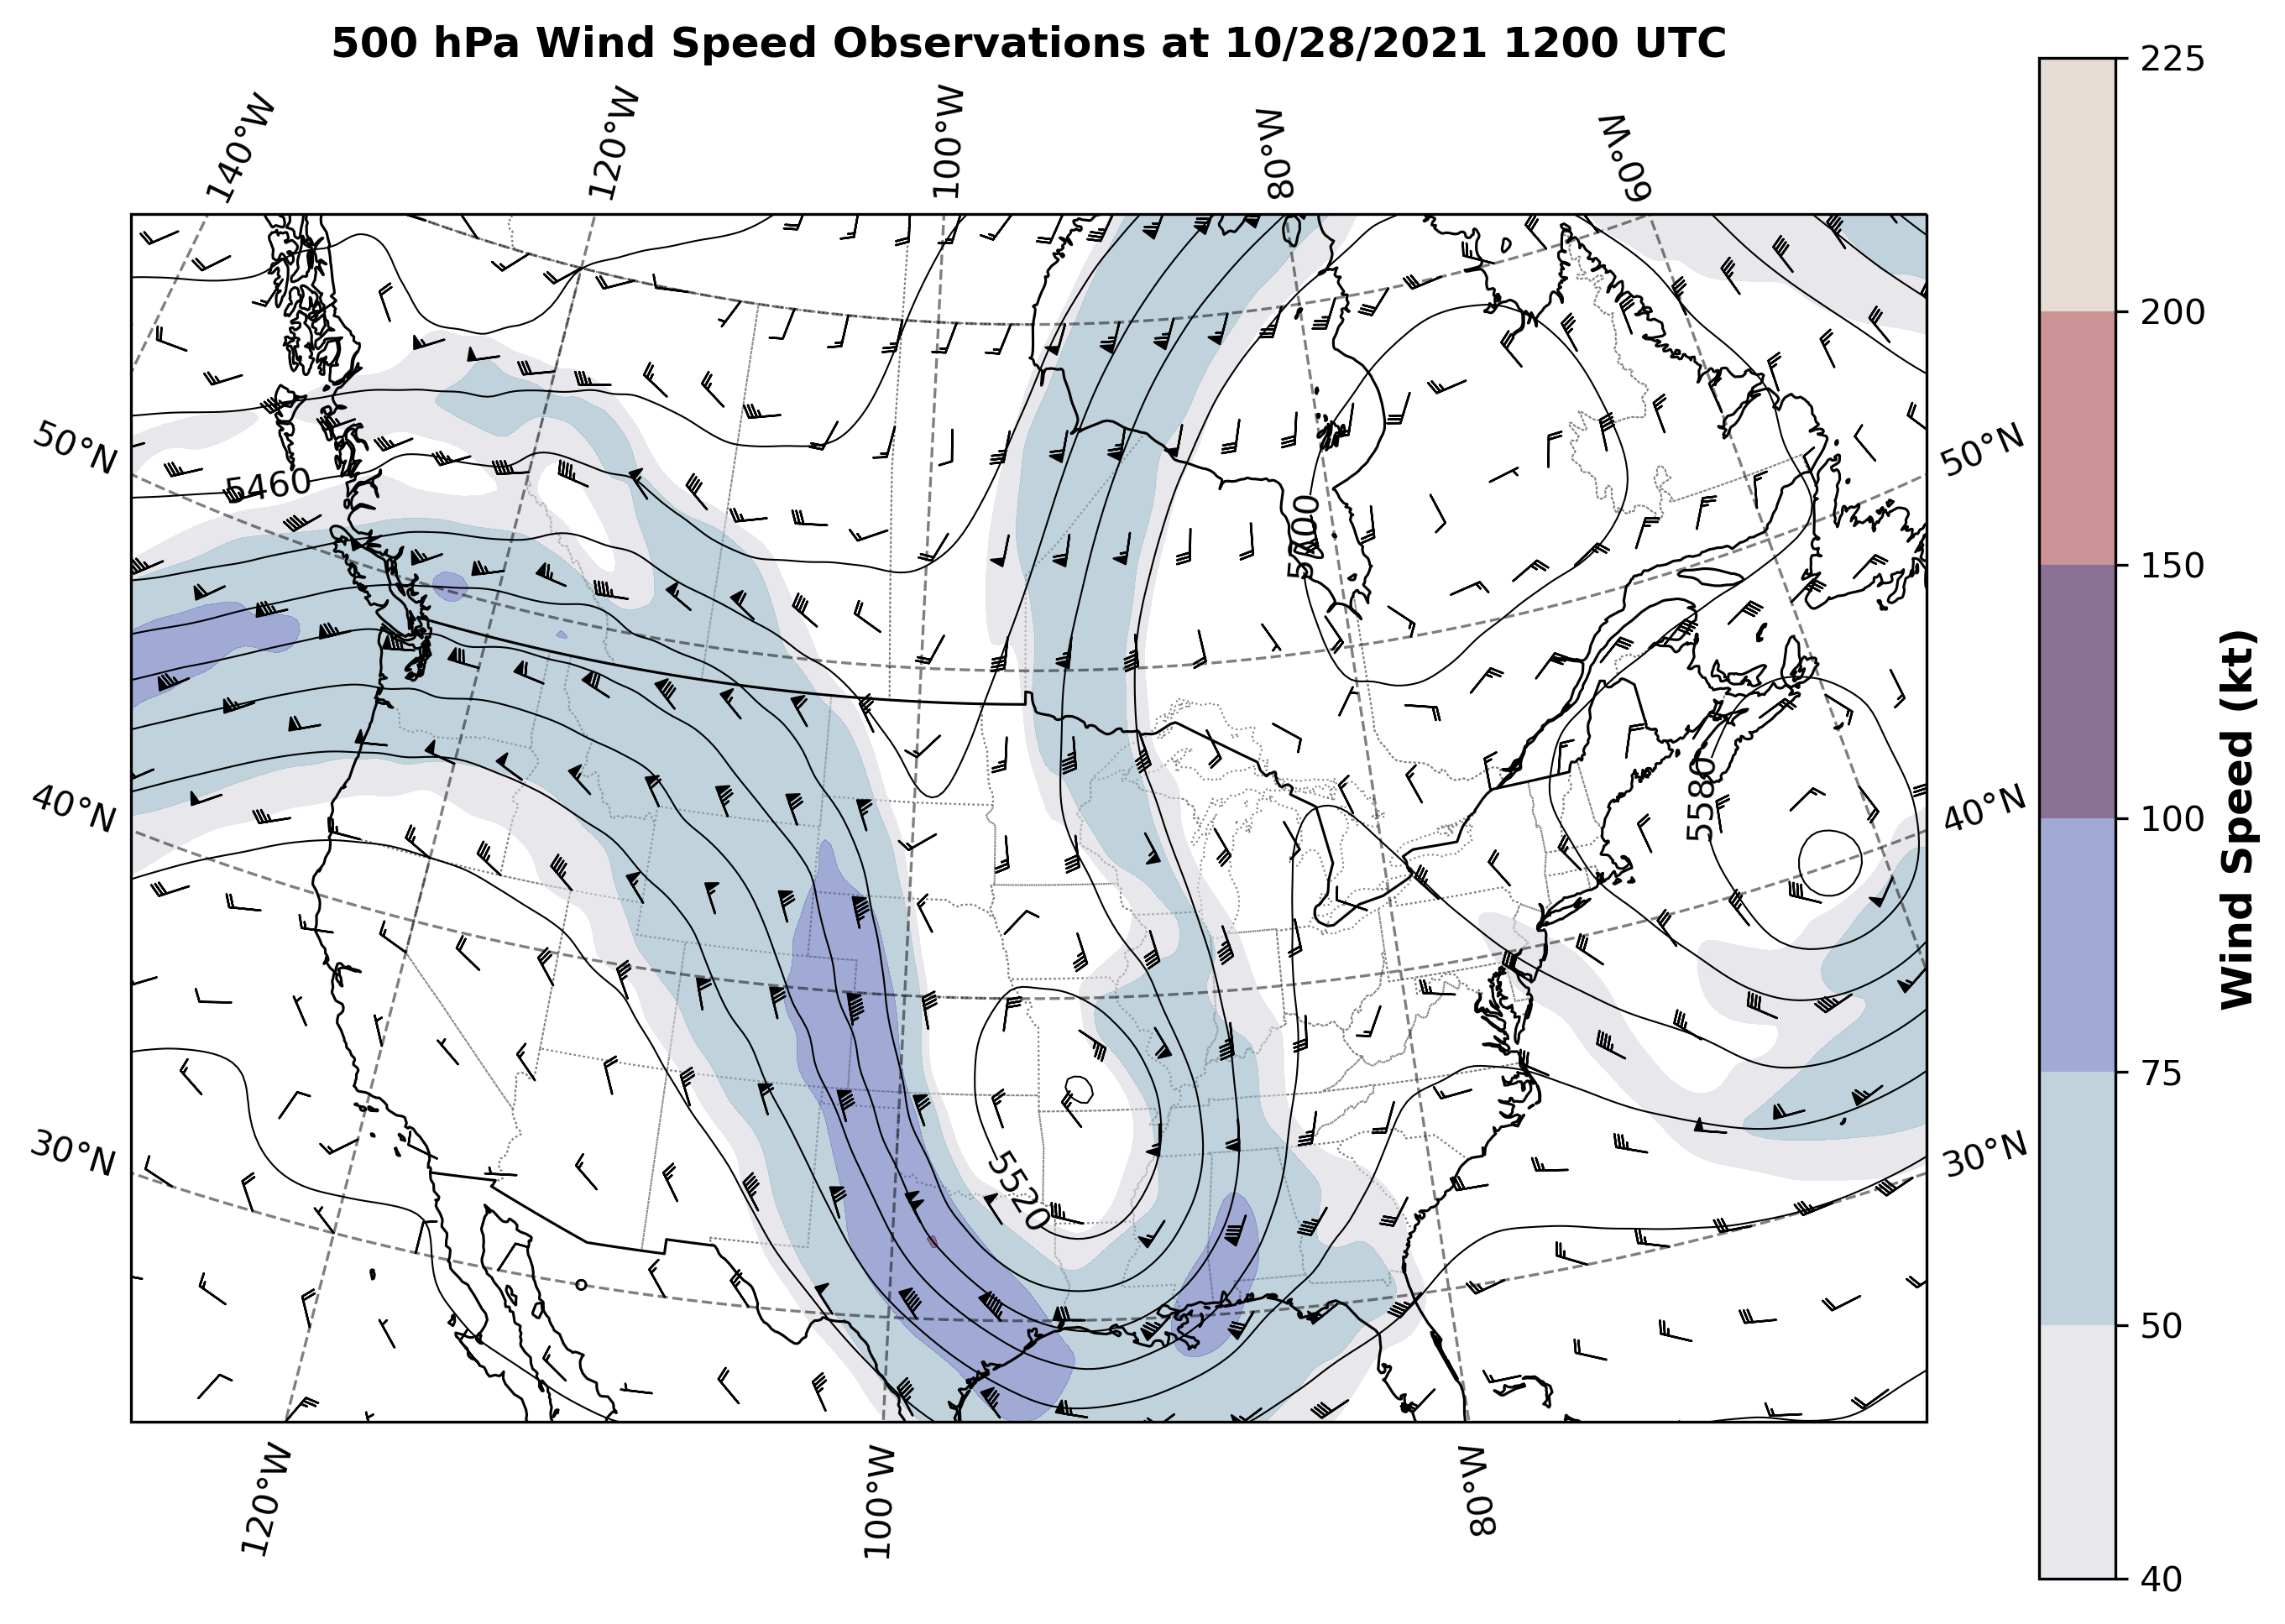

In [20]:
wind_gfs_upper_air_plot(leveled_data, level, map_time)

<br /><br />
7.  We also need an ageostrophic wind plot to supplement our wind plot.  In the function below, we create a plot of geopotential height (contours), color-filled contours for the ageostrophic wind speed, and vectors for the ageostrophic wind. 

In [21]:
"""
Below I define a function to plot upper-air ageostrophic  wind data.  This function creates line isoplehts for the geopotential  height, color fill isopleths 
for the ageostrophic wind magnitude, and wind vectors for the ageostrophic wind.

INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data
    level : INTEGER
        The level that the plot is valid for.
    data : DATETIME
        The date and time that the plot is valid for.



"""
def upper_air_ageostophic(model_data, level,date):
    """
    Initialize the plot using the function we created.
    """
    ax = initialize_plot()
    
    """
    As with previous labs, first we want to smooth the geopotential height data to make them easier to analyze.  
    Setup the Gaussian filter for the geopotential heights ('gh'). Choose an appropriate smoothing value for these data.
    """
    smooth_heights =gaussian_filter(model_data["gh"].values,2) 

    """
    We can now isopleth the smoothed geopotential height data.  In the line below, add the command to isopleth the smoothed 
    geopotential heights and add styling information to make the contours easier to read.
    """
    cont_p =plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,60),linewidths=0.5, colors="black", transform=crs.PlateCarree()) 
    
    """
    Every contour plot needs labels for each contour, so we add contour labels below.  Add styling information to make the contour labels easier to read.
    """
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'))          
              
    """
    Next, we plot color-filled contours for ageostrophic wind magnitude.  As with the geopotential height, though, we must first smooth the ageostrophic wind magnitude data.
    In the line below setup the gaussian filter for the ageostrophic wind magnitude data (ageostrophic_mag).
    """
    smooth_wind =gaussian_filter(model_data["ageostrophic_mag"].values,2) 
                        
    """
    In the line below, I plot the color-filled contours for the ageostrophic wind speed.  The color-fill contour command (plt.contourf) works similarly to the contour command (plt.contour).
    The first two arguments are the longitude and latitude data, respectively.
    The third argument is the field to contour, here being the smoothed ageostrophic wind.
    The fourth argument is the contour interval.  I specify every 10 kt starting at 10 kt and ending at 50 kt.
    The fifth argument is the color map to use to shade the color-filled contours.  This argument uses the same colormaps we looked at back in Lab 1.
    The sixth argument is the data's coordinate system.
    The seventh argument is the drawing order.  It is useful to plot color-filled contours early, otherwise color-filled contours will plot over other data.
    The eighth argument is the transparency of the color shading.  It is useful to reduce the transparency in color-filled plots to make the plot easier to read.
    The final argument is if we want to shade values outside our the range we specified.  The options are "max" for values that only exceed the range, "min" for 
    only values that fall below the range, or "both" for when you want to shade values that fall below and exceed the range specified.
    """
    cont = plt.contourf(model_data["longitude"].values, model_data["latitude"].values,smooth_wind, np.arange(10,60,10), cmap='twilight', transform=crs.PlateCarree(), zorder=1, alpha=0.4, extend="max")          
              
    """
    Next, we need to add a color bar to provide a reference to the shaded colors.  In the line below,
    I tell matplotlib to build a color bar from the color-filled contours we created before (cont).
    """
    cbar = plt.colorbar()
              
    """
    Our color bar needs a descriptive label.
    The first argument is the color bar label's text.
    The second argument is the color bar label's text size.  Larger values increase the text size and smaller values decrease the text size.
    The final argument is the text's weight.  This determines the text's boldness.
    """
    cbar.set_label("Wind Magnitude (kt)", size=12, weight="bold")
    
    """
    Now, we begin plotting the ageostrophic wind vectors.  The first part of setting up the ageostrophic wind vectors is determining how to space the data.  There are data points every 0.25° latitude
    and longitude, which is too frequent to be able to draw ageostrophic wind vector at every location.  Instead, we can space the ageostrophic wind vectors by skipping a specific number of data points.
    In the case below, we retain data only every 7 points (about ~150 km apart).  
    
    In the two lines below, I set a variable for x and y array slices to allow the user to have different values for numbers of points to skip 
    in the x and y direction.  The command I'm using is essentially like what you would use for an array.
    
    array[start:stop:skip] = array[slice(start,stop,skip)]
    
    Using 'None' for the start and stop arguments ensures the filtering applies to the entire dataset.
    """
    wind_slice_x = slice(None, None, 12)
    wind_slice_y = slice(None, None, 12)
            
    """
    To make our data easier to read, we apply a Gaussian filter to the u and v components of the ageostrophic wind.
    """
    u_smooth = gaussian_filter(model_data["u_ageostrophic"].values, 2)
    v_smooth = gaussian_filter(model_data["v_ageostrophic"].values, 2)                  
              
    """
    Below is the matplotlib command to plot vectors.  The first and second arguments are the x (longitude) and y (latitude) values, respectively.  
    Note that latitude and longitude are 1D whereas the ageostrophic wind variables are 2D.  Thus, for position data, we only need to use the wind slice direction that is appropriate.
    The third and fourth arguments are the u- and v-ageostrophic wind components.  We need to use both wind slices since our data is 2D.
    The fifth argument (color='black') determines the vector colors.  The matplotlib colors link can once again be used to see what colors you can use to plot the vectors.
    The sixth argument says what horizonal coordinate system the data are in.  
    The seventh argument (linewidth=0.6) determines the vector's width.  Larger values make them thicker and smaller values make them thinner.
    The eighth argument (scale_units="inches) units for the vector length.  It is best to use inches.
    The last argument is the scaling for the vectors.  Larger values make the vectors decrease in length, smaller values make the vectors increase in length.
    """
    q = ax.quiver(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             u_smooth[wind_slice_x, wind_slice_y],
             v_smooth[wind_slice_x, wind_slice_y],
             color='black',transform=crs.PlateCarree(),linewidth=0.6, scale_units='inches', scale=175)
    
    """
    Now that we have vectors, we need to have a key to help readers connect vector length to speed. 
    In the code below, I set up a reference vector to appear above our map on the right side.
    
    Argument one is the vector plot object from the code above.
    Arguments two and three are the x and y positions, respectively.
    Argument four is the magnitude that the vector is going to represent in the same units as the data.
    Argument five is the vector's desired label.
    Argument six is the label's position relative to the reference vector.  In this case, the label will
    plot to the right (or east) of the vector.
    Argument seven is the coordinate system that we are using in our x and y position to place our key.
    Here we use "axes" so we easily position the key in the plot by using values between 0 (far left/bottom) and 1 (far right/top).
    The last argument is the font properties.  Here we can add font sizing, font weight, and font type
    arguments to the label.
    """
    ax.quiverkey(q, 0.95, 1.05, 25.,'25 kt', labelpos='E', coordinates='axes',
                     fontproperties={'size':10})

    """
    Add latitude and longitude gridlines for reference.
    Argument one determines if the labels (e.g. 45°N) appear in the plot.
    Argument two determines if the labels are decimal degrees or degrees minutes seconds.  True is degreees mintues seconds
    and false is decimal degrees.
    Argument three determines if the longitude value labels are plotted on the line inside the plot or outside.  True is
    inside the plot and false is outside the plot.
    Argument four determines if the latitude value labels are plotted on the line inside the plot or outside.  True is
    inside the plot and false is outside the plot.
    The last three arguments are normal matplotlib styling arguments.
    """
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='k', alpha=0.6,linestyle='--')
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
    plot_title= f"{str(level)} hPa Ageostrophic Wind Vectors at {map_time:%m/%d/%Y %H%M} UTC"
    plt.title(plot_title, weight="bold")
    plt.show()     


<br /><br /> 
8. Call the ageostrophic wind plot function you just created for the time and level we specified earlier.

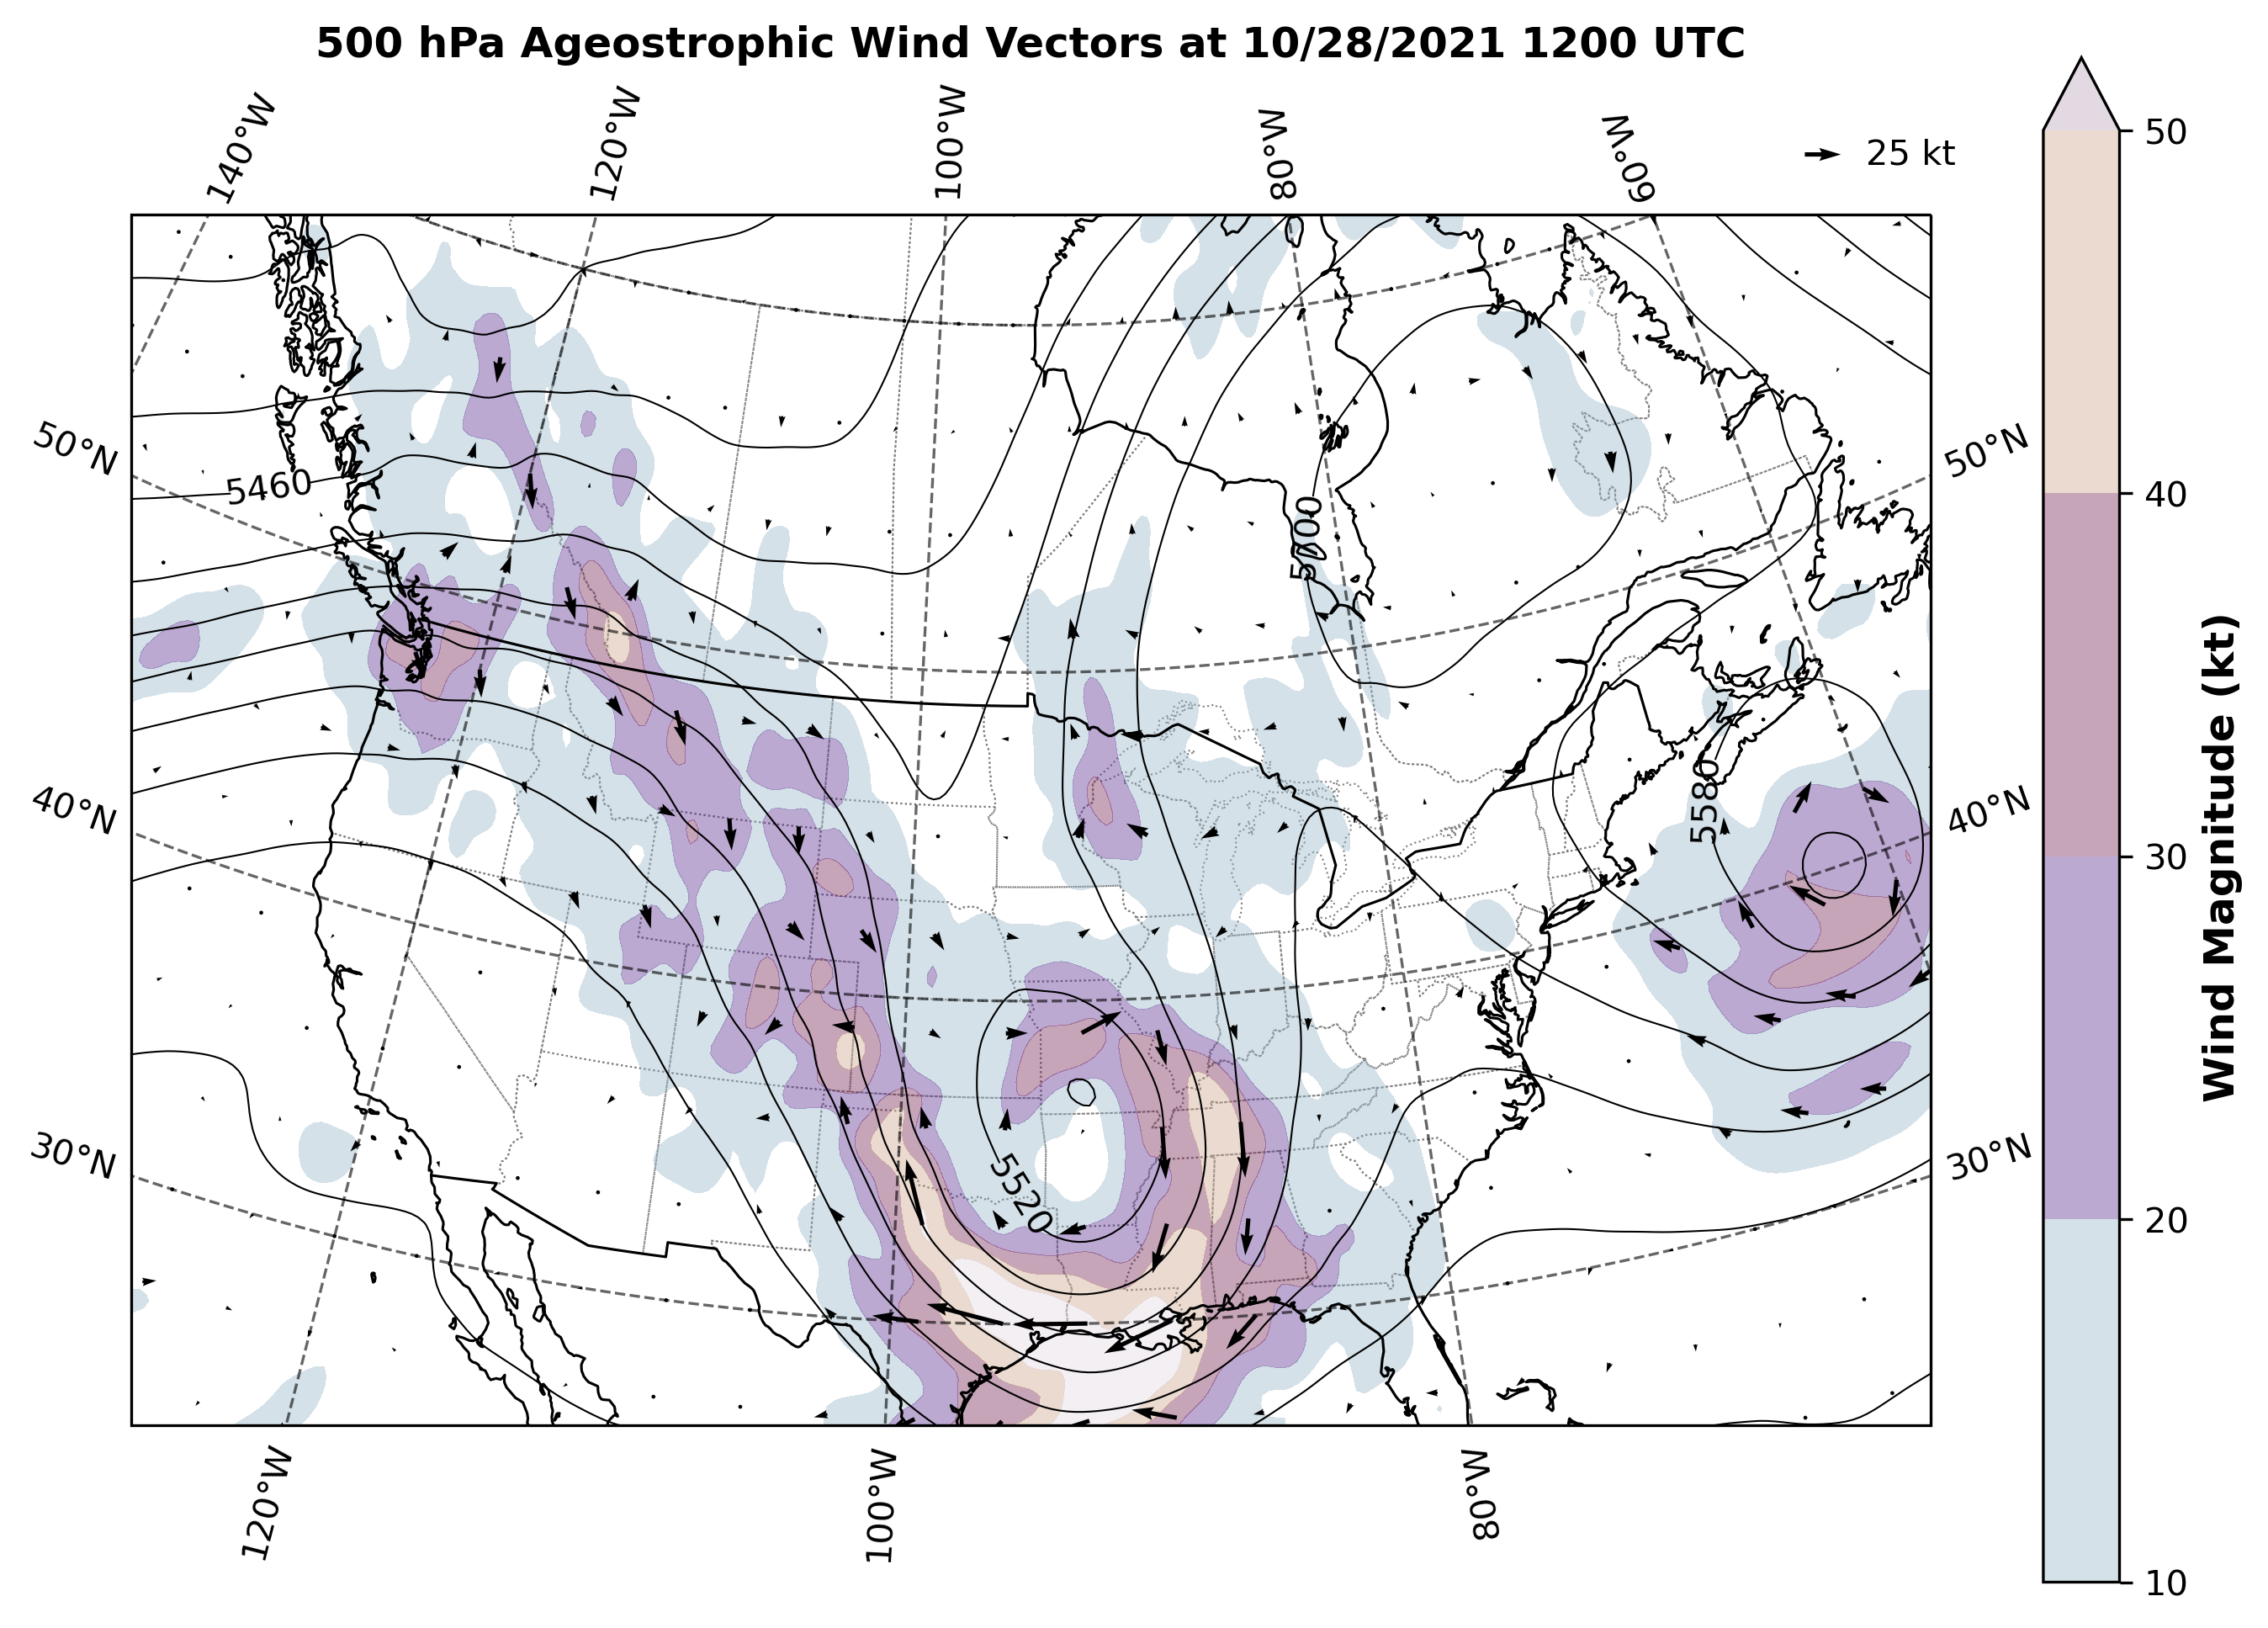

In [22]:
upper_air_ageostophic(leveled_data, level,map_time)

<br /><br />
9. Finally, we also wish to generate plots for 1200 UTC February 3, 2022 at 300 hPa.  Re-run the data-processing function and both plotting functions you created to generate the necessary plots for this time.

Ignoring index file '/data/AtmSci360/Lab_6/020322_12_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

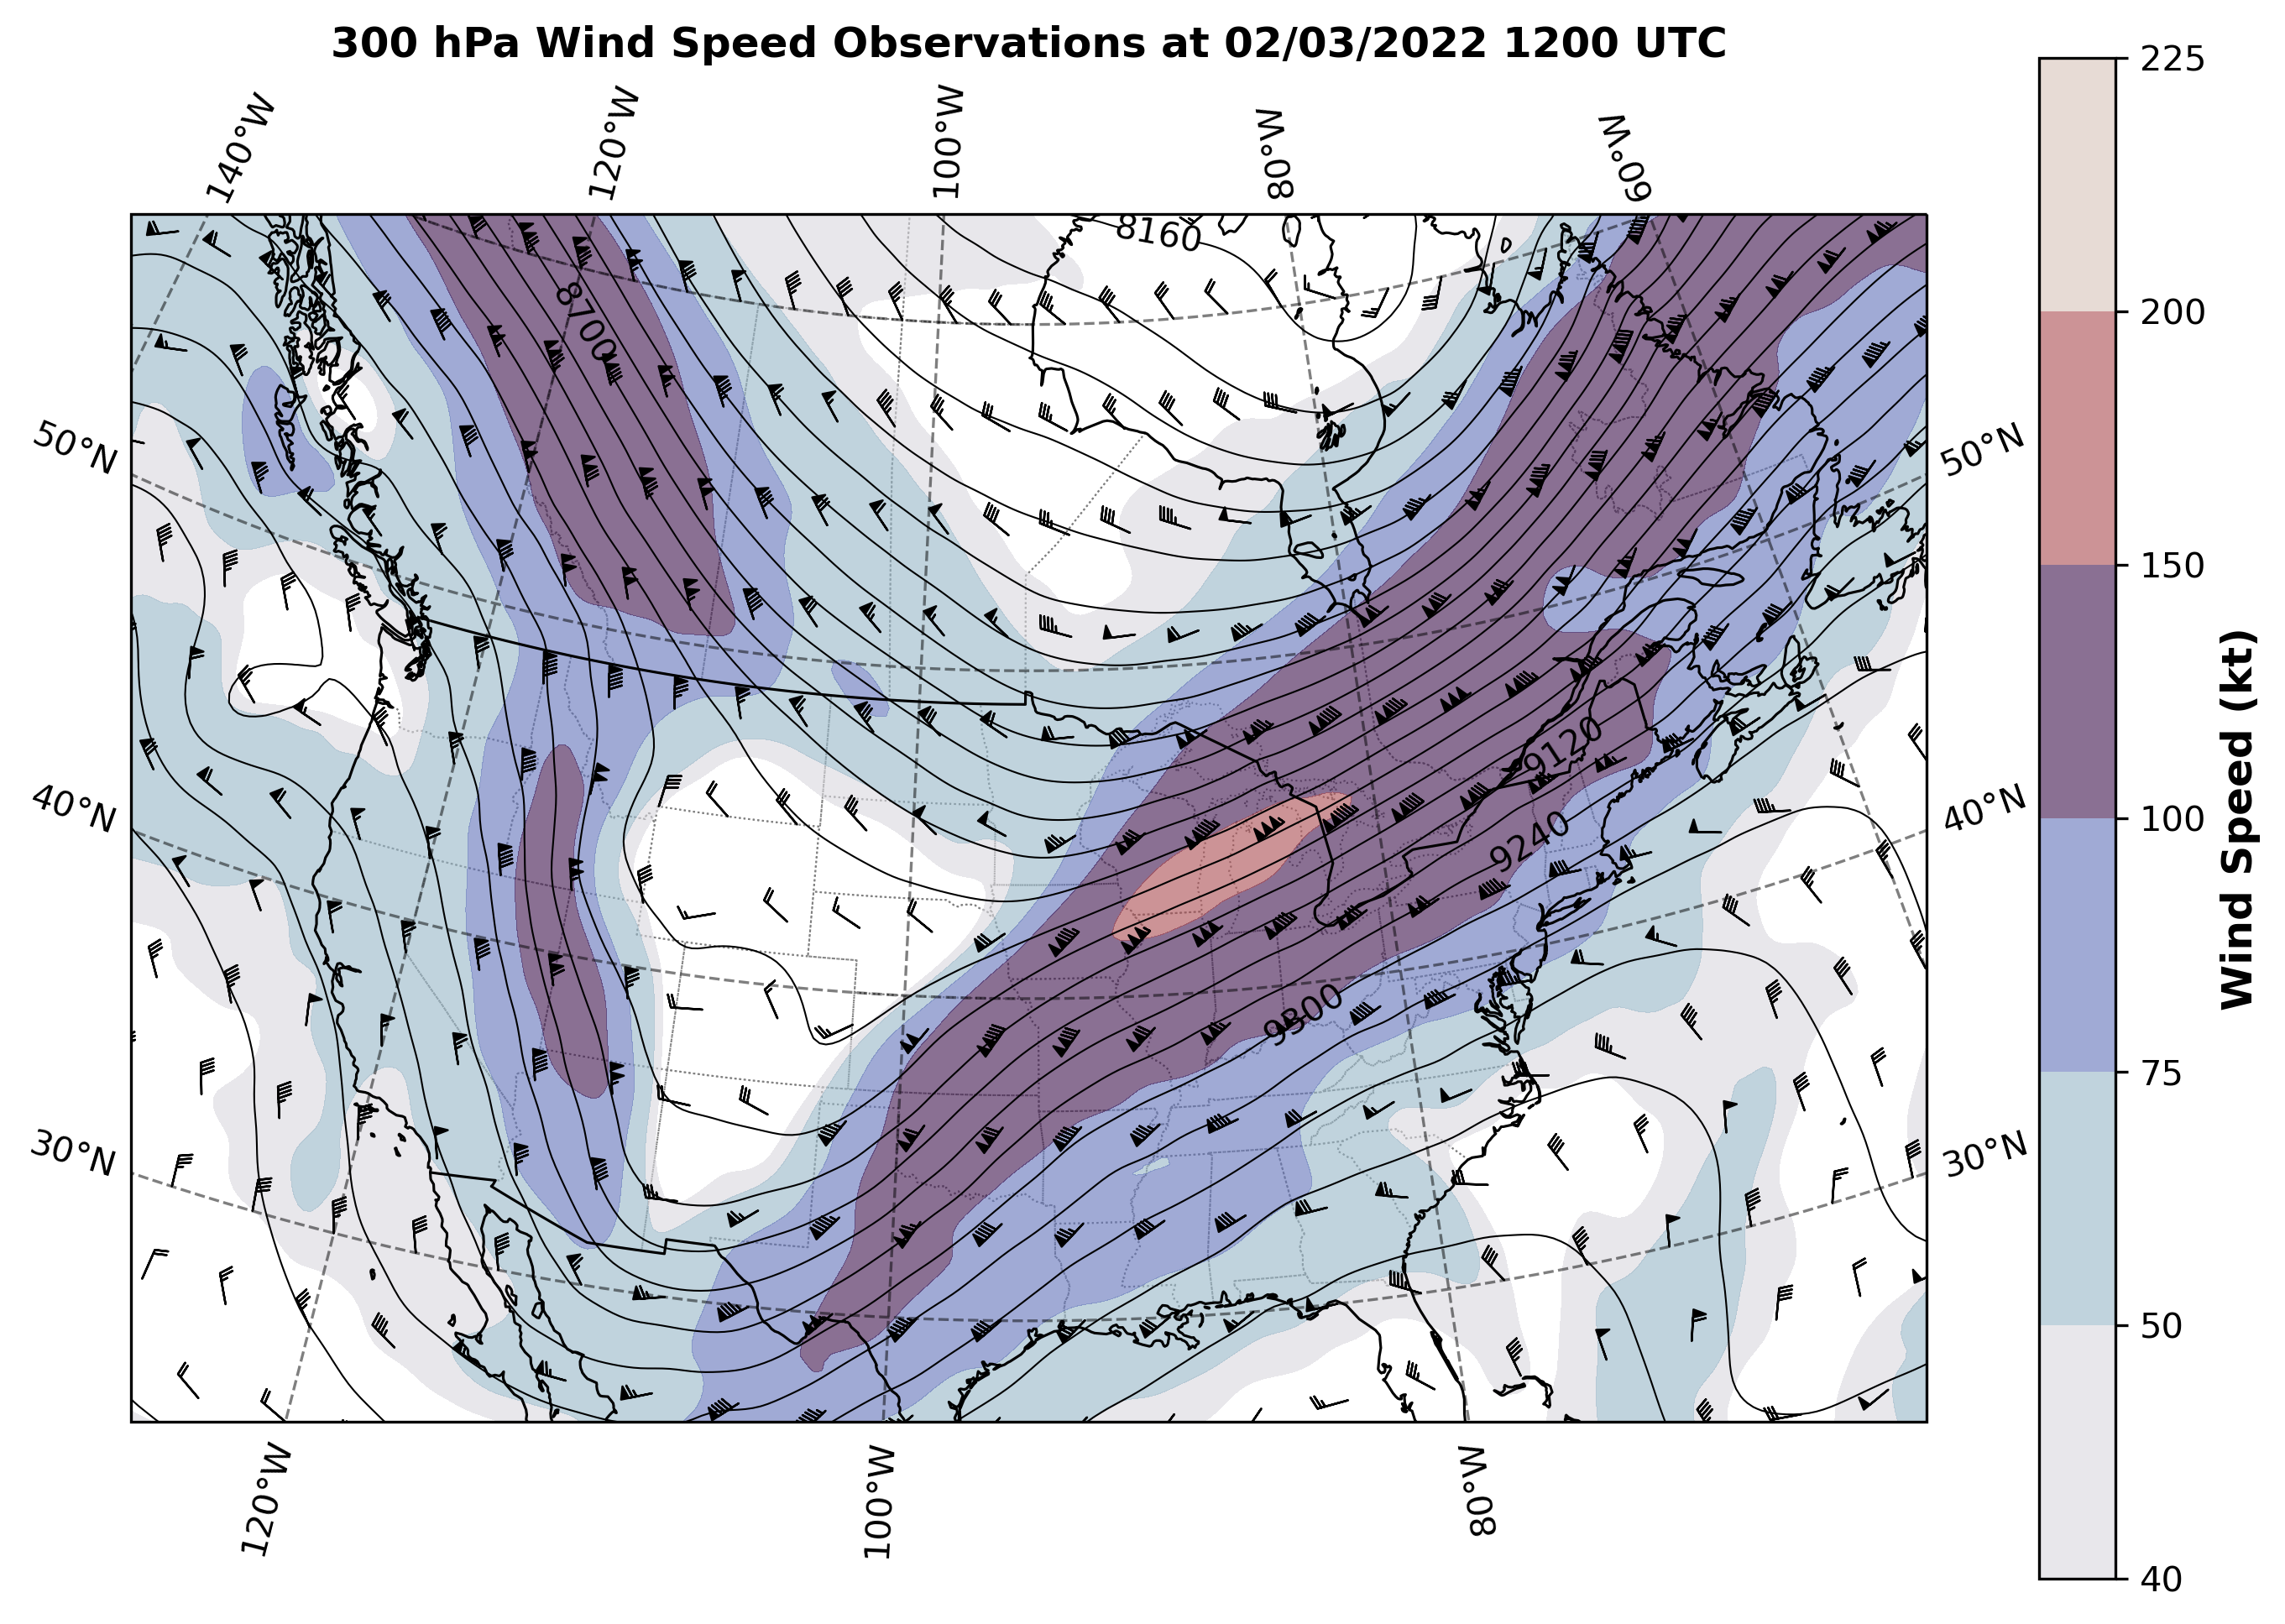

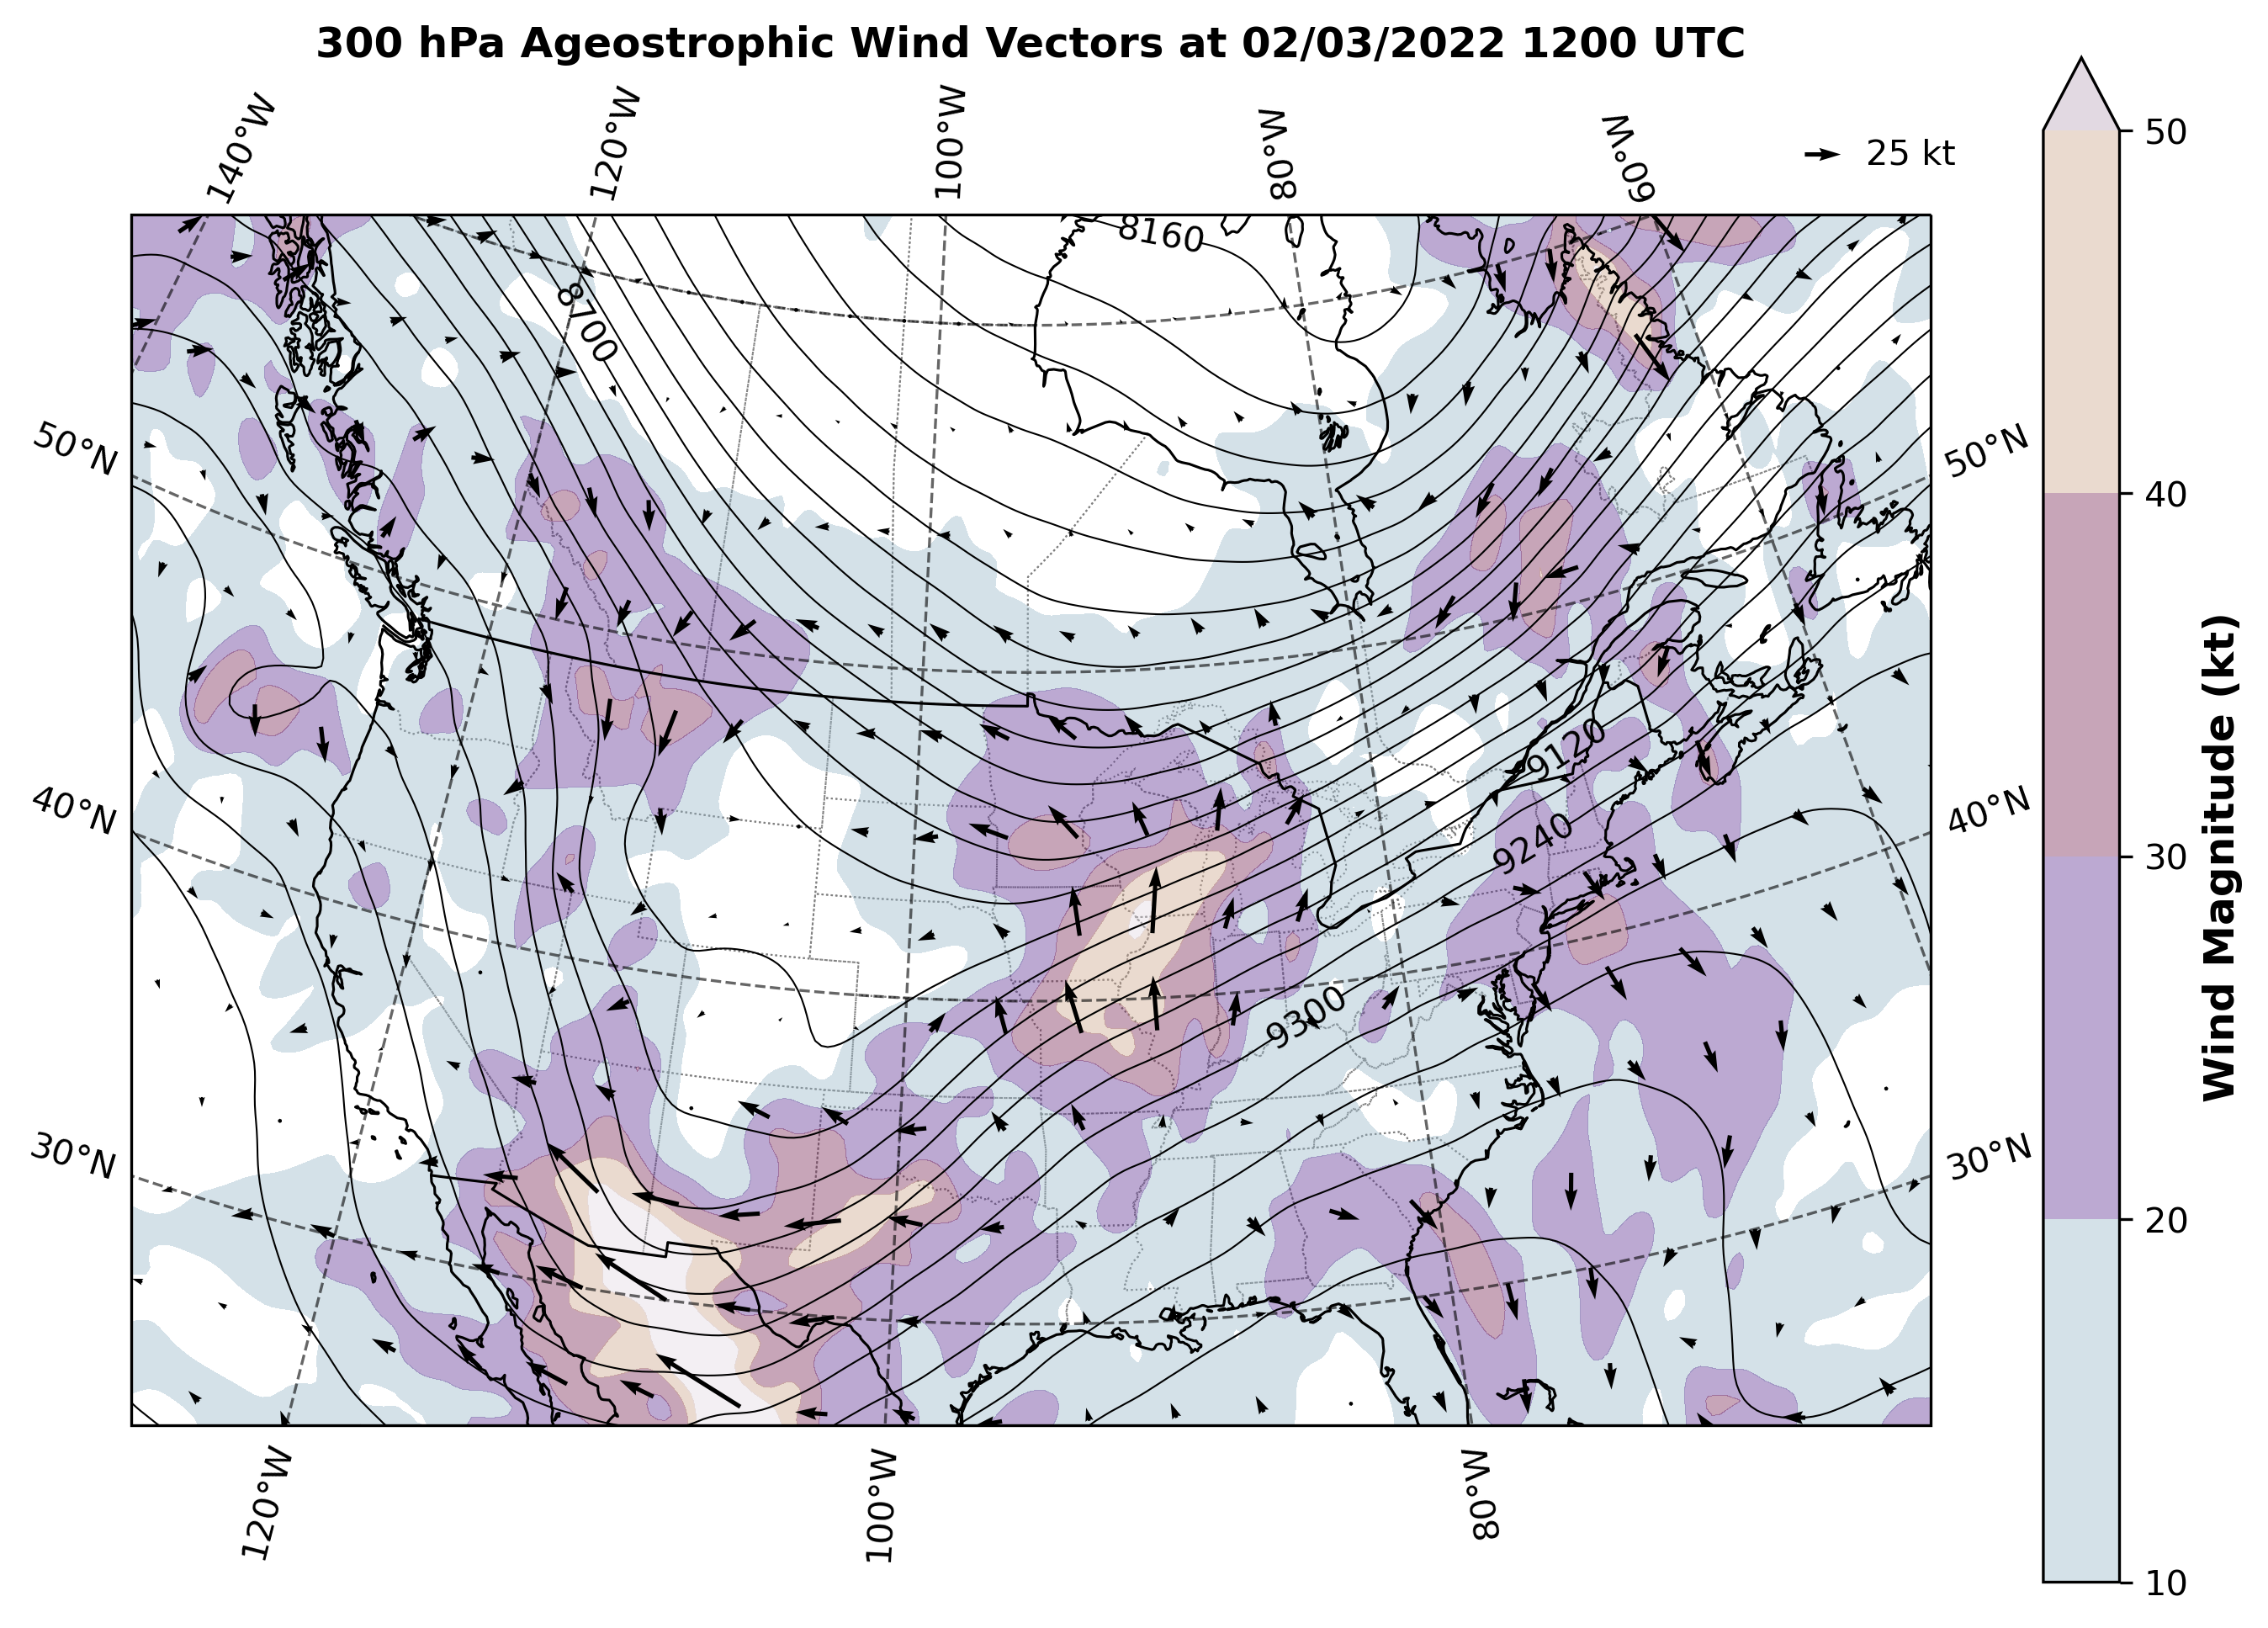

In [23]:

from datetime import datetime
import numpy as np
import cartopy.crs as crs 
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import xarray as xr
from metpy.units import units
import metpy.calc as calc
map_time=datetime(2022,2,3,12)
level=300
leveled_data=process_upper_air_data(level,map_time)
wind_gfs_upper_air_plot(leveled_data, level, map_time)
upper_air_ageostophic(leveled_data, level,map_time)

### You have now completed the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.